# BA2

Author: Carmen Fischer

Data: https://www.bgc-jena.mpg.de/wetter/weather_data.html

1. Comparison of different Neural nets: ARIMA, CNN and LSTM
2. Different amount of training data: 1 year, 5 years, 10 years, 20 years
3. Different Optimizer
4. Differnt Loss
5. Different Prodiction Windows
6. Different Input dimensions (measurments)

In [1]:
# needed imports
#todo: rsme berechnung am validation dataset
from pathlib import Path
import zipfile
import pandas as pd
import glob
import numpy as np
import copy
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace import sarimax
import datetime
import math
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
print('import done')

import done


In [2]:
# needed global variables
duration = {}
rmse = {}

In [3]:
# extract data from zip
zip_path = Path('/home/c2110475134/BA2/BachelorArbeit2/data') #needs absolut path, modify for own setup
file_path = Path(str(zip_path) + '/mpi_saale_2002b.csv')

if not(file_path.is_file()):
    zip_file = Path(str(zip_path) + '/data.zip')
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(zip_path)
    
print('extracting done')

extracting done


In [4]:
# makes pandas dataframe out of all csv extracted in previous cell
all_files = glob.glob(str(zip_path) + '/*.csv')

df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

print('dataframe done')

dataframe done


In [5]:
# statistics of the  uncleaned data
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),1200817.0,984.132170,413.274897,-9999.0,994.40,1000.05,1005.49,1098.50
T (degC),1200817.0,-1.960084,346.016156,-9999.0,3.96,9.67,15.74,39.69
rh (%),1200817.0,61.673814,410.029511,-9999.0,66.07,82.20,95.10,100.00
sh (g/kg),1200817.0,-15.938216,471.360917,-9999.0,4.09,5.82,8.20,20.14
Tpot (K),1200817.0,266.752028,411.013038,-9999.0,277.11,282.95,289.00,313.06
Tdew (degC),1200817.0,-14.351434,448.366106,-9999.0,1.00,5.95,10.97,25.15
VPmax (mbar),1200817.0,2.105614,346.152952,-9999.0,8.11,12.02,17.91,72.60
VPact (mbar),1200817.0,-8.205157,427.660035,-9999.0,6.57,9.32,13.11,32.01
VPdef (mbar),1200817.0,-14.309347,427.413241,-9999.0,0.42,1.79,4.96,62.79
H2OC (mmol/mol),1200817.0,-12.154130,471.552210,-9999.0,6.57,9.33,13.12,31.99


In [6]:
# data clean up
bad_data = -9999.0

# remove rows where any column has bad data
df.dropna()
df = df[~df.isin([bad_data]).any(axis=1)]

print('clean up done')

clean up done


In [7]:
# statistics of the cleaned data
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),1162530.0,999.648539,8.988539,854.40,994.40,1000.08,1005.51,1038.41
T (degC),1162530.0,10.016045,8.305642,-45.03,4.01,9.69,15.72,39.69
rh (%),1162530.0,78.306702,19.061072,0.00,66.07,82.20,95.10,100.00
sh (g/kg),1162530.0,6.305859,2.766910,0.00,4.10,5.83,8.18,20.14
Tpot (K),1162530.0,283.208427,8.407761,228.39,277.17,282.97,288.98,313.06
Tdew (degC),1162530.0,5.765722,6.946298,-96.29,1.03,5.96,10.93,25.15
VPmax (mbar),1162530.0,14.069830,8.142490,0.10,8.14,12.04,17.89,72.60
VPact (mbar),1162530.0,10.083910,4.398466,0.00,6.58,9.33,13.08,32.01
VPdef (mbar),1162530.0,3.985993,5.647849,0.00,0.42,1.81,4.98,62.79
H2OC (mmol/mol),1162530.0,10.091957,4.410086,0.00,6.58,9.34,13.09,31.99


In [8]:
# normalize wind direction
wv = df.pop('wv (m/s)')

# convert degrees to radians because the absolute distance between them is smaller
wd_rad = df.pop('wd (deg)') * np.pi / 180

# calculate the wind x and y components
df['Wx'] = wv * np.cos(wd_rad)
df['Wy'] = wv * np.sin(wd_rad)

# parse timestamps to convert them into a more suitable linear representation 
df['Date Time'] = pd.to_datetime(
    df['Date Time'], 
    format='%d.%m.%Y %H:%M:%S', 
    utc=True#01.07.2018 00:10:04
)

date_time = df['Date Time']
timestamp_s = date_time.map(pd.Timestamp.timestamp)


DAY = 24 * 60 * 60
YEAR = (365.2425) * DAY

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / DAY))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / DAY))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / YEAR))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / YEAR))

print('normalisation done')

normalisation done


In [9]:
# statistics of the normized wind direction and time data
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),1162530.0,999.648539,8.988539,854.400000,994.400000,1.000080e+03,1005.510000,1038.410000
T (degC),1162530.0,10.016045,8.305642,-45.030000,4.010000,9.690000e+00,15.720000,39.690000
rh (%),1162530.0,78.306702,19.061072,0.000000,66.070000,8.220000e+01,95.100000,100.000000
sh (g/kg),1162530.0,6.305859,2.766910,0.000000,4.100000,5.830000e+00,8.180000,20.140000
Tpot (K),1162530.0,283.208427,8.407761,228.390000,277.170000,2.829700e+02,288.980000,313.060000
Tdew (degC),1162530.0,5.765722,6.946298,-96.290000,1.030000,5.960000e+00,10.930000,25.150000
VPmax (mbar),1162530.0,14.069830,8.142490,0.100000,8.140000,1.204000e+01,17.890000,72.600000
VPact (mbar),1162530.0,10.083910,4.398466,0.000000,6.580000,9.330000e+00,13.080000,32.010000
VPdef (mbar),1162530.0,3.985993,5.647849,0.000000,0.420000,1.810000e+00,4.980000,62.790000
H2OC (mmol/mol),1162530.0,10.091957,4.410086,0.000000,6.580000,9.340000e+00,13.090000,31.990000


In [10]:
#split data in traing, validation and test data
df_train = copy.deepcopy(df[df['Date Time'] < '2023-01-01'])
df_val = copy.deepcopy(df[(df['Date Time'] >= '2023-01-01') & (df['Date Time'] <= '2023-12-31')])
df_test = (copy.deepcopy(df[df['Date Time'] > '2023-12-31']))

print('data split done')

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df_train = df_train.select_dtypes(include=numerics)
df_val = df_val.select_dtypes(include=numerics)
df_test = df_test.select_dtypes(include=numerics)

df_train_mean = df_train.mean(numeric_only=True)
df_train_std = df_train.std(numeric_only=True)

df_train = (df_train - df_train_mean) / df_train_std
df_val = (df_val - df_train_mean) / df_train_std
df_test = (df_test - df_train_mean) / df_train_std

print('Data normalisation done')

# set data and label type depending on hardware
if torch.cuda.is_available():
    print('cuda:0')
    device = torch.device('cuda:0')
    dtype = torch.float32
    ltype = torch.float32
else:
    print('cpu')
    device = torch.device('cpu')
    dtype = torch.float32
    ltype = torch.float32

# definiton of dataset
class WeatherDataset(Dataset):
     def __init__(self, data, labels, label_width):
        self.data = data
        self.labels = labels
        self.label_width = label_width
        self.dtype = dtype
         
     def __len__(self):
        return len(self.data) - self.label_width

     def __getitem__(self, idx):
        X = self.data.iloc[idx:idx+self.label_width, :].values
        y = self.labels[idx + self.label_width]
        
        return torch.tensor(X, dtype=dtype), torch.tensor(y, dtype=dtype)

train_label = df_train['T (degC)'].values
val_label = df_val['T (degC)'].values
test_label = df_test['T (degC)'].values

LABEL_WIDTH = 24*6 #measurements are taken every 10 min

train_dataset = WeatherDataset(df_train, train_label, LABEL_WIDTH)
val_dataset = WeatherDataset(df_val, val_label, LABEL_WIDTH)
test_dataset = WeatherDataset(df_test, test_label, LABEL_WIDTH)

data split done
Data normalisation done
cuda:0


In [11]:
BATCH_SIZE = 32
DIMENSIONS = df_train.shape[1]
MAX_EPOCHS = 10

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)  # Use an appropriate batch size
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

device = get_device()

#train method
def train(model,
          train_loader, 
          test_loader,
          optimizer,
          epochs = MAX_EPOCHS,
          critertion = nn.MSELoss()
         ):
    # Loss and optimizer
    criterion = critertion
    optimizer = optimizer
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            # pivot 
            targets = targets.unsqueeze(1)
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            
            loss = criterion(outputs, targets)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()


        # Train loss
        train_losses[epoch] = running_loss / len(train_loader)

        # Test loss
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                targets = targets.unsqueeze(1)
                inputs, targets = inputs.to(device), targets.to(device)
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()

        test_losses[epoch] = test_loss / len(test_loader)
        print(f'At epoch {epoch+1}/{epochs}, Train Loss: {train_losses[epoch]:.3f}, Test Loss: {test_losses[epoch]:.3f}')

    return train_losses, test_losses

# SARIMA
In TSF seasonal autoregressive integrated moving average (SARIMA) models is a generalizations of autoregressive moving average (ARMA) to predict non-stationary series with periodic variation. The goal is to predict future values, by fitting the data as well as possible. As the TS is non stationary the the (seasonal) trend is removed by seasonal differencing. [1] [2]

[1] Asteriou, Dimitros; Hall, Stephen G. (2011). "ARIMA Models and the Box–Jenkins Methodology". Applied Econometrics (Second ed.). Palgrave MacMillan. pp. 265–286. ISBN 978-0-230-27182-1.

[2] Mills, Terence C. (1990). Time Series Techniques for Economists. Cambridge University Press. ISBN 978-0-521-34339-8.

In [31]:
model_type = 'sarima'
start_time = datetime.datetime.now()
# split data in traing, validation and test data
df_sarima_train = copy.deepcopy(df[df['Date Time'] < '2023-01-01'])
df_sarima_val = copy.deepcopy(df[(df['Date Time'] >= '2023-01-01') & (df['Date Time'] <= '2023-12-31')])
df_sarima_test = (copy.deepcopy(df[df['Date Time'] > '2023-12-31']))

df_sarima_train.drop(['Day sin', 'Day cos', 'Year sin', 'Year cos'], axis=1, inplace=True)
df_sarima_val.drop(['Day sin', 'Day cos', 'Year sin', 'Year cos'], axis=1, inplace=True)
df_sarima_test.drop(['Day sin', 'Day cos', 'Year sin', 'Year cos'], axis=1, inplace=True)

print('SARIMA data split done')

SARIMA data split done


In [32]:
#set index to column 'Date Time' with the datetime datatype
df_sarima_train['Date Time'] = pd.to_datetime(df_sarima_train['Date Time'])
df_sarima_val['Date Time'] = pd.to_datetime(df_sarima_val['Date Time'])
df_sarima_test['Date Time'] = pd.to_datetime(df_sarima_test['Date Time'])

df_sarima_train = df_sarima_train.set_index('Date Time')
df_sarima_val = df_sarima_val.set_index('Date Time')
df_sarima_test = df_sarima_test.set_index('Date Time')

print('SARIMA data indexing done')

SARIMA data indexing done


In [33]:
#group data by month, otherwise not feasable with current computing power
df_sarima_train = df_sarima_train.groupby([df_sarima_train.index.year, df_sarima_train.index.month]).mean(numeric_only=True)
df_sarima_val = df_sarima_val.groupby([df_sarima_val.index.year, df_sarima_val.index.month]).mean(numeric_only=True)
df_sarima_test = df_sarima_test.groupby([df_sarima_test.index.year, df_sarima_test.index.month]).mean(numeric_only=True)

#reset indexing so the model can handel the databetter
df_sarima_train.reset_index(drop=True, inplace=True)
df_sarima_val.reset_index(drop=True, inplace=True)
df_sarima_test.reset_index(drop=True, inplace=True)

df_sarima_train_mean = df_sarima_train.mean()
df_sarima_train_std = df_sarima_train.std()

df_sarima_train = (df_sarima_train - df_sarima_train_mean) / df_sarima_train_std
df_sarima_val = (df_sarima_val - df_sarima_train_mean) / df_sarima_train_std
df_sarima_test = (df_sarima_test - df_sarima_train_mean) / df_sarima_train_std

print('SARIMA data aggregation done')

SARIMA data aggregation done


ADF Statistic: -14.460340
p-value: 0.000000
number of observations: 235
Critical Values:
	1%: -3.998
	5%: -3.429
	10%: -3.138


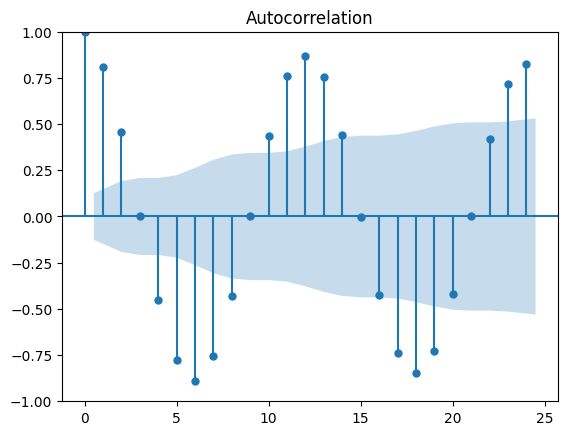

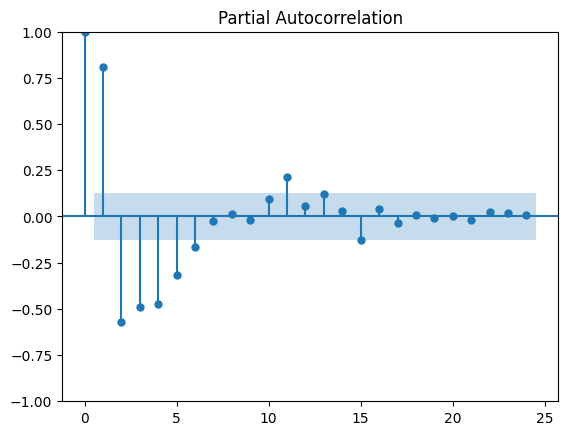

In [34]:
plot_acf(df_sarima_train['T (degC)']) #shows autocorrelation
plot_pacf(df_sarima_train['T (degC)']) #shows partial autocorrelation

#stationary test using the augumented Dickey-Fuller test (when ADF < Critical Value 5% TS is stationary)
result = adfuller(df_sarima_train['T (degC)'], regression='ct', autolag = 'BIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('number of observations: %i' % result[3])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

In [35]:
#fitting the model and makeing the predictions

#order tupel: 
#p: candidates are meaningfull spikes of partial autocorrelation (1-7)
#d: 0 because ADF shows stationary
#q: candidates are meaningfull spikes of autocorrelation (1-3), best fit 3
#seasonal_order tupel
#P: 0 as  long-term autoregression does not make much sense
#D: same as order tupel
#Q: same as order tupel
#seasonality: 12 as monthly data
for i in range(12):
    sarimax_model = sarimax.SARIMAX(df_sarima_train['T (degC)'], 
                            order = (1,0,3), 
                            seasonal_order = (0,1,3,12), 
                            enforce_stationarity=False,
                            enforce_invertibility=False)
    result = sarimax_model.fit()
    result.predict(i).values[0]

print(result.summary())

#calculate the RMSE
sum_difference = 0
observed = df_sarima_val['T (degC)']
for i in range(12):
    prediction = (result.predict(i+12)).values[0] #predict the value
    sum_difference += (prediction - observed[i]) ** 2

performance = 0
performance = math.sqrt(sum_difference / 12)
end_time = datetime.datetime.now()

rmse[model_type] = performance
duration[model_type] = end_time - start_time

                                     SARIMAX Results                                      
Dep. Variable:                           T (degC)   No. Observations:                  241
Model:             SARIMAX(1, 0, 3)x(0, 1, 3, 12)   Log Likelihood                 -34.042
Date:                            Sat, 10 May 2025   AIC                             84.084
Time:                                    12:16:38   BIC                            110.018
Sample:                                         0   HQIC                            94.590
                                            - 241                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7121      0.334      2.134      0.033       0.058       1.366
ma.L1         -0.5574      0.343   

# 1D CNN
Convolutional neural networks (CNN) are a type of feedforward neural network that learn features by itself via filter (or kernel) optimization[3]. CNNs are also known as shift invariant or space invariant artificial neural networks, based on the shared-weight architecture of the convolution kernels or filters that slide along input features and provide translation-equivariant responses known as feature maps [4].

[3] LeCun, Yann; Bengio, Yoshua; Hinton, Geoffrey (2015-05-28). "Deep learning". Nature. 521 (7553): 436–444. Bibcode:2015Natur.521..436L. doi:10.1038/nature14539. ISSN 1476-4687

[4] Zhang, Wei (1988). "Shift-invariant pattern recognition neural network and its optical architecture". Proceedings of Annual Conference of the Japan Society of Applied Physics.

In [12]:
model_type = 'casualCNN1D'
start_time = datetime.datetime.now()

In [13]:
class CausalConvolution1d(torch.nn.Conv1d):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dilation=1,
                 groups=1,
                 bias=True):

        super(CausalConvolution1d, self).__init__(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=0,
            dilation=dilation,
            groups=groups,
            bias=bias)
        
        self.__padding = (kernel_size - 1) * dilation
        
    def forward(self, input):
        return super(CausalConvolution1d, self).forward(F.pad(input, (self.__padding, 0)))

In [14]:
class DilatedCNN(nn.Module):
    
    def __init__(self,):
        super(DilatedCNN, self).__init__()

        self.dilation1 = CausalConvolution1d(in_channels=144,out_channels=32,kernel_size=2,
                                dilation=1)
        self.dilation2 = CausalConvolution1d(in_channels=32,out_channels=32,kernel_size=2,
                                dilation=2)
        self.dilation3 = CausalConvolution1d(in_channels=32,out_channels=32,kernel_size=2,
                                dilation=4)
        self.dilation4 = CausalConvolution1d(in_channels=32,out_channels=32,kernel_size=2,
                                dilation=8)
        self.dilation5 = CausalConvolution1d(in_channels=32,out_channels=16,kernel_size=2,
                                dilation=16)
        
        self.fc1 = nn.Linear(160,32)
        self.drop1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(32,1)
    
    def forward(self, x):
        
        # for predicting y0(y at timestep 0), we need to use
        # x-value at the last timestep.
        x_now = x.clone()[:,:,-1]
        x = torch.relu(self.dilation1(x))
        x = torch.relu(self.dilation2(x))
        x = torch.relu(self.dilation3(x))
        x = torch.relu(self.dilation4(x))
        x = torch.relu(self.dilation5(x))
        
        x = x[:,:,-1]
        # batch_size, features, time_steps -> batch_size, features
        # take only the last timestep
        
        x = torch.cat([x,x_now], axis=1)
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = self.fc2(x)

        return x

In [15]:
model_cnn = DilatedCNN()
model_cnn = model_cnn.to(device)
    
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.01)
criterion = nn.MSELoss()

total_parameters = sum(p.numel() for p in model_cnn.parameters())
print(f"total number of parameters = {total_parameters}")

total number of parameters = 21713


In [16]:
train_losses, test_losses = train(model_cnn,
                                   train_loader,
                                   test_loader,
                                   optimizer,
                                   epochs = MAX_EPOCHS,
                                   critertion = criterion)

At epoch 1/10, Train Loss: 0.593, Test Loss: 1.934
At epoch 2/10, Train Loss: 0.543, Test Loss: 1.934
At epoch 3/10, Train Loss: 0.543, Test Loss: 1.934
At epoch 4/10, Train Loss: 0.543, Test Loss: 1.934
At epoch 5/10, Train Loss: 0.543, Test Loss: 1.934
At epoch 6/10, Train Loss: 0.543, Test Loss: 1.934
At epoch 7/10, Train Loss: 0.543, Test Loss: 1.934
At epoch 8/10, Train Loss: 0.543, Test Loss: 1.934
At epoch 9/10, Train Loss: 0.543, Test Loss: 1.934
At epoch 10/10, Train Loss: 0.543, Test Loss: 1.934


In [17]:
# calculation RMSE
sum_difference = 0

for inputs, labels in val_dataset:
    target = labels.item()

    unsqueezed = inputs.unsqueeze(0)
    predicted = model_cnn(unsqueezed.to(device))

    sum_difference += (predicted - target) ** 2

In [18]:
end_time = datetime.datetime.now()
rmse[model_type] = math.sqrt(sum_difference / len(val_dataset))
duration[model_type] = end_time - start_time

In [19]:
print(rmse)
print(duration)

{'casualCNN1D': 1.077932865879787}
{'casualCNN1D': datetime.timedelta(seconds=2102, microseconds=442935)}


# LSTM
Long short-term memory (LSTM) is a type of recurrent neural network that aims to eliviate the vanishing gradient problem. [5]

[5] Hochreiter, Sepp (1991). Untersuchungen zu dynamischen neuronalen Netzen (diploma thesis). Technical University Munich, Institute of Computer Science.

In [20]:
model_type = 'lstm'
start_time = datetime.datetime.now()

In [21]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=layer_dim,
            batch_first=True
        )
        # batch_first to have (batch_dim, seq_dim, feature_dim)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1, :])
        return out

In [22]:
lstm_model = LSTM(DIMENSIONS, 32, 1, 1)
lstm_model.to(device)

optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
criterion = nn.MSELoss()

total_parameters = sum(p.numel() for p in lstm_model.parameters())
print(f"total number of parameters = {total_parameters}")

total number of parameters = 8609


In [23]:
# Training the model with the DataLoader
train_losses, test_losses = train(lstm_model,
                                   train_loader,
                                   test_loader,
                                   optimizer,
                                   epochs = MAX_EPOCHS,
                                   critertion = criterion)

At epoch 1/10, Train Loss: 0.014, Test Loss: 0.036
At epoch 2/10, Train Loss: 0.010, Test Loss: 0.026
At epoch 3/10, Train Loss: 0.009, Test Loss: 0.040
At epoch 4/10, Train Loss: 0.010, Test Loss: 0.048
At epoch 5/10, Train Loss: 0.010, Test Loss: 0.064
At epoch 6/10, Train Loss: 0.010, Test Loss: 0.012
At epoch 7/10, Train Loss: 0.008, Test Loss: 0.010
At epoch 8/10, Train Loss: 0.009, Test Loss: 0.037
At epoch 9/10, Train Loss: 0.008, Test Loss: 0.016
At epoch 10/10, Train Loss: 0.007, Test Loss: 0.041


In [81]:
# calculation RMSE
sum_difference = 0

for inputs, labels in val_dataset:
    target = labels.item()

    unsqueezed = inputs.unsqueeze(0)
    predicted = lstm_model(unsqueezed.to(device))

    sum_difference += (predicted - target) ** 2

predicted tensor([[-0.3484]], device='cuda:0', grad_fn=<AddmmBackward0>)
target 0.0022388657089322805
predicted tensor([[-0.3043]], device='cuda:0', grad_fn=<AddmmBackward0>)
target 0.06001877784729004
predicted tensor([[-0.2420]], device='cuda:0', grad_fn=<AddmmBackward0>)
target 0.3513258397579193
predicted tensor([[0.1818]], device='cuda:0', grad_fn=<AddmmBackward0>)
target 0.6570779085159302
predicted tensor([[0.3074]], device='cuda:0', grad_fn=<AddmmBackward0>)
target 0.7064315676689148
predicted tensor([[0.3063]], device='cuda:0', grad_fn=<AddmmBackward0>)
target 0.7112465500831604
predicted tensor([[0.3064]], device='cuda:0', grad_fn=<AddmmBackward0>)
target 0.6907828450202942
predicted tensor([[0.2924]], device='cuda:0', grad_fn=<AddmmBackward0>)
target 0.6883753538131714
predicted tensor([[0.2985]], device='cuda:0', grad_fn=<AddmmBackward0>)
target 0.6943941116333008
predicted tensor([[0.3011]], device='cuda:0', grad_fn=<AddmmBackward0>)
target 0.6992090940475464
predicted ten

KeyboardInterrupt: 

In [82]:
end_time = datetime.datetime.now()
rmse[model_type] = math.sqrt(sum_difference / len(val_dataset))
duration[model_type] = end_time - start_time

In [26]:
print(rmse)
print(duration)

{'casualCNN1D': 1.077932865879787, 'lstm': 0.1884128581489141}
{'casualCNN1D': datetime.timedelta(seconds=2102, microseconds=442935), 'lstm': datetime.timedelta(seconds=1583, microseconds=928320)}


# GRUs

Gated Recurrent Units (GRUs) are a type of gating mechanism used in recurrent neural networks (RNNs) [6]. Similar to Long Short-Term Memory (LSTM) networks, GRUs employ gating to control the flow of information, allowing them to retain or discard specific features. However, unlike LSTMs, GRUs do not include an output gate or a context vector, making them simpler and more efficient with fewer parameters [7] [8].

[6] Cho, Kyunghyun; van Merrienboer, Bart; Bahdanau, DZmitry; Bougares, Fethi; Schwenk, Holger; Bengio, Yoshua (2014). "Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation".

[7] Felix Gers; Jürgen Schmidhuber; Fred Cummins (1999). "Learning to forget: Continual prediction with LSTM". 9th International Conference on Artificial Neural Networks: ICANN '99. Vol. 1999. pp. 850–855. doi:10.1049/cp:19991218

[8]  "Recurrent Neural Network Tutorial, Part 4 – Implementing a GRU/LSTM RNN with Python and Theano – WildML". Wildml.com. 2015-10-27. Archived from the original

In [12]:
model_type = 'gru'
start_time = datetime.datetime.now()

In [13]:
class GRU_model(nn.Module):
    
    def __init__(self):
        super(GRU_model, self).__init__()
        self.gru1 = nn.GRU(input_size=144,hidden_size=32,num_layers=2,batch_first=True)
        self.fc1 = nn.Linear(32,1)
        self.fc2 = nn.Linear(1,1)
    
    def forward(self,x):
        x = x.transpose(1,2)
        x,l = self.gru1(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x[:, -1, :])

In [14]:
gru_model = GRU_model()
gru_model.to(device)

optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.01)
criterion = nn.MSELoss()

total_parameters = sum(p.numel() for p in gru_model.parameters())
print(f"total number of parameters = {total_parameters}")

total number of parameters = 23459


In [15]:
train_losses, test_losses = train(gru_model,
                                   train_loader,
                                   test_loader,
                                   optimizer,
                                   epochs = MAX_EPOCHS,
                                   critertion = criterion)

At epoch 1/10, Train Loss: 0.539, Test Loss: 1.934
At epoch 2/10, Train Loss: 0.543, Test Loss: 1.934
At epoch 3/10, Train Loss: 0.543, Test Loss: 1.934
At epoch 4/10, Train Loss: 0.543, Test Loss: 1.934
At epoch 5/10, Train Loss: 0.543, Test Loss: 1.934
At epoch 6/10, Train Loss: 0.543, Test Loss: 1.934
At epoch 7/10, Train Loss: 0.543, Test Loss: 1.934
At epoch 8/10, Train Loss: 0.543, Test Loss: 1.934
At epoch 9/10, Train Loss: 0.543, Test Loss: 1.934
At epoch 10/10, Train Loss: 0.543, Test Loss: 1.934


In [16]:
#calculation RMSE
sum_difference = 0

for inputs, labels in val_dataset:
    target = labels.item()

    unsqueezed = inputs.unsqueeze(0)
    predicted = gru_model(unsqueezed.to(device))
    sum_difference += (predicted - target) ** 2

In [17]:
end_time = datetime.datetime.now()
rmse[model_type] = math.sqrt(sum_difference / len(val_dataset))
duration[model_type] = end_time - start_time

In [18]:
print(rmse)
print(duration)

{'gru': 1.2591540840945818}
{'gru': datetime.timedelta(seconds=1814, microseconds=723019)}
